### Covid-19 Cases Prediction ###
- The purpose of this assesment is to predict the next 30 days cases that will happen in Malaysia
- The dataset consist of two files: cases_malaysia_train.csv & cases_malaysia_test.csv
- We will completed this project using Bi-directional LSTM with less than or equal 64 layers and windows size set to 30 days.

In [1]:
#1. Setup - import packages

import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from time_series_helper import WindowGenerator


mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

In [2]:
#2. Set Path
CSV_PATH_TRAIN = os.path.join(os.getcwd(), 'cases_malaysia_train.csv')
CSV_PATH_TEST = os.path.join(os.getcwd(), 'cases_malaysia_test.csv')

In [3]:
#3. Load the Data
train_df = pd.read_csv(CSV_PATH_TRAIN)
print(train_df.info())
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     680 non-null    object 
 1   cases_new                680 non-null    object 
 2   cases_import             680 non-null    int64  
 3   cases_recovered          680 non-null    int64  
 4   cases_active             680 non-null    int64  
 5   cases_cluster            680 non-null    int64  
 6   cases_unvax              680 non-null    int64  
 7   cases_pvax               680 non-null    int64  
 8   cases_fvax               680 non-null    int64  
 9   cases_boost              680 non-null    int64  
 10  cases_child              680 non-null    int64  
 11  cases_adolescent         680 non-null    int64  
 12  cases_adult              680 non-null    int64  
 13  cases_elderly            680 non-null    int64  
 14  cases_0_4                6

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,cases_boost,...,cases_60_69,cases_70_79,cases_80,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
0,25/1/2020,4,4,0,4,0,4,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26/1/2020,0,0,0,4,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27/1/2020,0,0,0,4,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,28/1/2020,0,0,0,4,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,29/1/2020,3,3,0,7,0,3,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
test_df = pd.read_csv(CSV_PATH_TEST)
print(test_df.info())
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     100 non-null    object 
 1   cases_new                99 non-null     float64
 2   cases_import             100 non-null    int64  
 3   cases_recovered          100 non-null    int64  
 4   cases_active             100 non-null    int64  
 5   cases_cluster            100 non-null    int64  
 6   cases_unvax              100 non-null    int64  
 7   cases_pvax               100 non-null    int64  
 8   cases_fvax               100 non-null    int64  
 9   cases_boost              100 non-null    int64  
 10  cases_child              100 non-null    int64  
 11  cases_adolescent         100 non-null    int64  
 12  cases_adult              100 non-null    int64  
 13  cases_elderly            100 non-null    int64  
 14  cases_0_4                10

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,cases_boost,...,cases_60_69,cases_70_79,cases_80,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
0,5/12/2021,4298.0,23,4928,61813,136,1017,38,3093,150,...,330,130,49,0,13,3,12,69,0,39
1,6/12/2021,4262.0,15,5894,60139,97,1036,39,3056,131,...,352,141,49,0,10,0,2,30,0,55
2,7/12/2021,4965.0,29,4817,60251,138,1130,46,3642,147,...,395,169,81,0,3,13,39,36,0,47
3,8/12/2021,5020.0,17,4525,60709,154,1162,41,3674,143,...,378,154,43,0,2,3,0,32,1,116
4,9/12/2021,5446.0,20,5427,60700,367,1207,53,4034,152,...,367,161,46,0,0,1,8,153,0,205


In [5]:
#4 - Exploratory Data Analysis
def preprocess_data(df):
    # (A) Convert date column datatype
    # Extract out the date column and convert it into datetime format
    date_column = pd.to_datetime(df.pop('date'), format="%d/%m/%Y")
    # Confirm the new datatype
    print('The new datatype is:', type(date_column[0]))

    # (B) Convert 'cases_new' to numerical format, handling non-integer values
    if df['cases_new'].dtype == 'O':
        non_numeric_mask = df['cases_new'].str.contains(r'[^0-9]', na=False)
        non_numeric = df.loc[non_numeric_mask, 'cases_new']
        non_numeric_indices = df.index[non_numeric_mask]
        print("\nRows with non-numeric characters:")
        print(non_numeric)

        # Replace the missing str values with their previous rows
        df['cases_new'] = df['cases_new'].str.replace(' ', '')
        df['cases_new'] = df['cases_new'].str.replace('?', '')
        df['cases_new'] = pd.to_numeric(df['cases_new'].replace('', float('nan')).ffill(), errors='coerce').astype('float32')

        # Confirm again there are no non-integer values and check their type
        numeric_indices = non_numeric_indices
        numeric = df.loc[numeric_indices, 'cases_new']
        print("\nRows with new changed numeric value:")
        print(numeric)
    else:
        df['cases_new'].astype('float32')

    # Ensure 'cases_new' is of type float32
    if df['cases_new'].dtype != 'float32':
        df['cases_new'] = df['cases_new'].astype('float32')

    df['cases_new'].fillna(method='ffill', inplace =True)
    df = df.astype('float32')
    df = df.fillna(0)
    
    return df, date_column

In [6]:
train_df, train_date = preprocess_data(train_df)
test_df, test_date = preprocess_data(test_df)

The new datatype is: <class 'pandas._libs.tslibs.timestamps.Timestamp'>

Rows with non-numeric characters:
98      
217     
273    ?
279     
287     
427    ?
445    ?
446    ?
476     
587    ?
615     
640    ?
Name: cases_new, dtype: object

Rows with new changed numeric value:
98        69.0
217       10.0
273      710.0
279      649.0
287     1755.0
427     1275.0
445     1767.0
446     1767.0
476     4113.0
587    20988.0
615    12735.0
640     4782.0
Name: cases_new, dtype: float32
The new datatype is: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


C:\Users\nazmi\AppData\Local\Temp\ipykernel_27120\2719484768.py:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['cases_new'].fillna(method='ffill', inplace =True)
C:\Users\nazmi\AppData\Local\Temp\ipykernel_27120\2719484768.py:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['cases_new'].fillna(method='ffill', inplace =True)


In [7]:
# Check the first date and last date of the data
def minmaxdate(df):
    min_date = train_date.dt.date.min()
    max_date = test_date.dt.date.max()
    print('The first and last date of the train data:', min_date, '-', max_date)

minmaxdate(train_df)
minmaxdate(test_df)

The first and last date of the train data: 2020-01-25 - 2022-03-14
The first and last date of the train data: 2020-01-25 - 2022-03-14


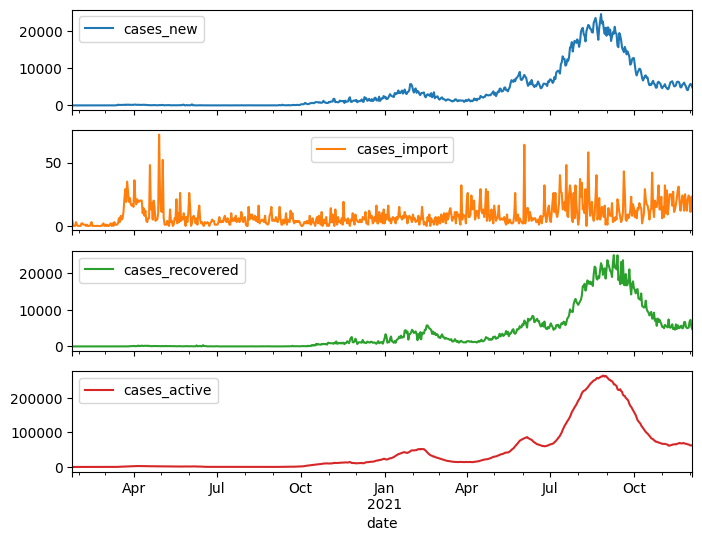

In [8]:
# (C) Inspecting Data Trending
plot_cols = ['cases_new', 'cases_import', 'cases_recovered', 'cases_active']
plot_features = train_df[plot_cols]
plot_features.index = train_date
_ = plot_features.plot(subplots=True)

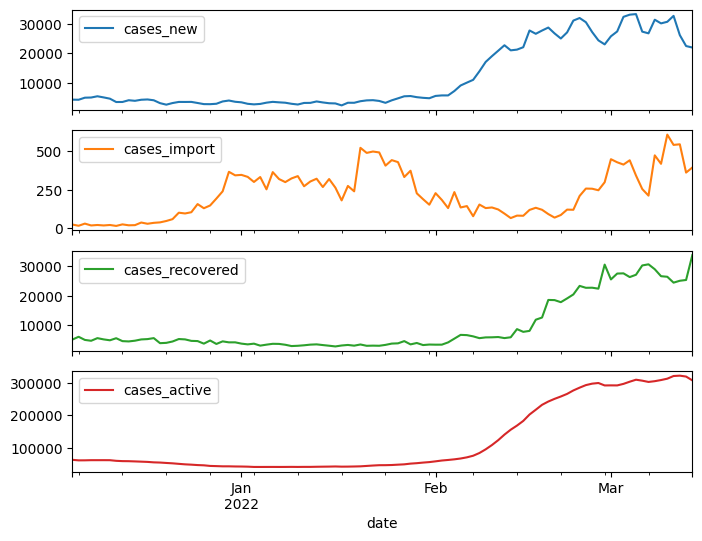

In [9]:
plot_cols = ['cases_new', 'cases_import', 'cases_recovered','cases_active']
plot_features = test_df[plot_cols]
plot_features.index = test_date
_ = plot_features.plot(subplots=True)

In [10]:
#(D) More EDA
def describe_data(df, df_name):
    print(f"If there is null values in the `{df_name}`")
    print(df.isnull().any())
    # Replace the Null values with 0
    df = df.fillna(0)
    print(f"Recheck againd if the null values is fix")
    print(df.isnull().any())
    print(f"\nThe description of the `{df_name}`")
    print(df.describe().transpose())
    print(f"\nIf there is duplicated data in the `{df_name}`")
    print(df.duplicated().any())
    print("#####")

describe_data(train_df, df_name='train_df')
describe_data(train_df, df_name='test_df')


If there is null values in the `train_df`
cases_new                  False
cases_import               False
cases_recovered            False
cases_active               False
cases_cluster              False
cases_unvax                False
cases_pvax                 False
cases_fvax                 False
cases_boost                False
cases_child                False
cases_adolescent           False
cases_adult                False
cases_elderly              False
cases_0_4                  False
cases_5_11                 False
cases_12_17                False
cases_18_29                False
cases_30_39                False
cases_40_49                False
cases_50_59                False
cases_60_69                False
cases_70_79                False
cases_80                   False
cluster_import             False
cluster_religious          False
cluster_community          False
cluster_highRisk           False
cluster_education          False
cluster_detentionCentre    False
c

In [11]:
# Confirmation on the Datatype has changed to float32
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cases_new                680 non-null    float32
 1   cases_import             680 non-null    float32
 2   cases_recovered          680 non-null    float32
 3   cases_active             680 non-null    float32
 4   cases_cluster            680 non-null    float32
 5   cases_unvax              680 non-null    float32
 6   cases_pvax               680 non-null    float32
 7   cases_fvax               680 non-null    float32
 8   cases_boost              680 non-null    float32
 9   cases_child              680 non-null    float32
 10  cases_adolescent         680 non-null    float32
 11  cases_adult              680 non-null    float32
 12  cases_elderly            680 non-null    float32
 13  cases_0_4                680 non-null    float32
 14  cases_5_11               6

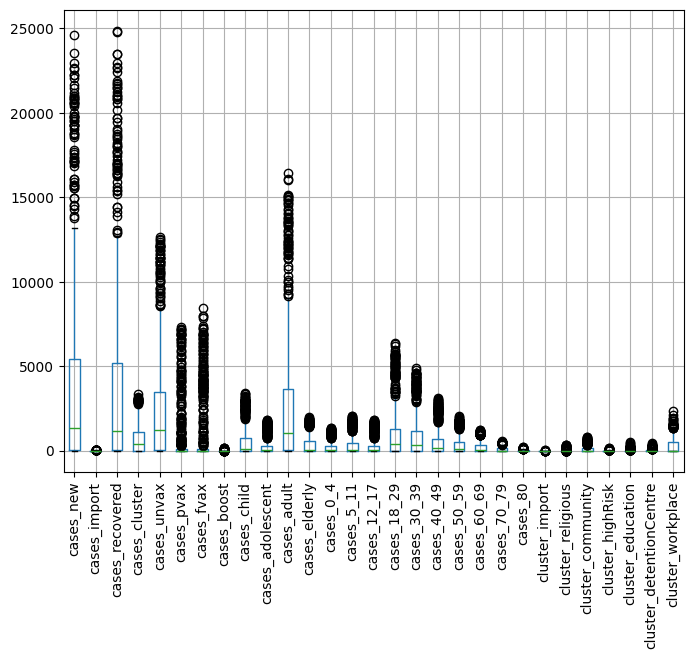

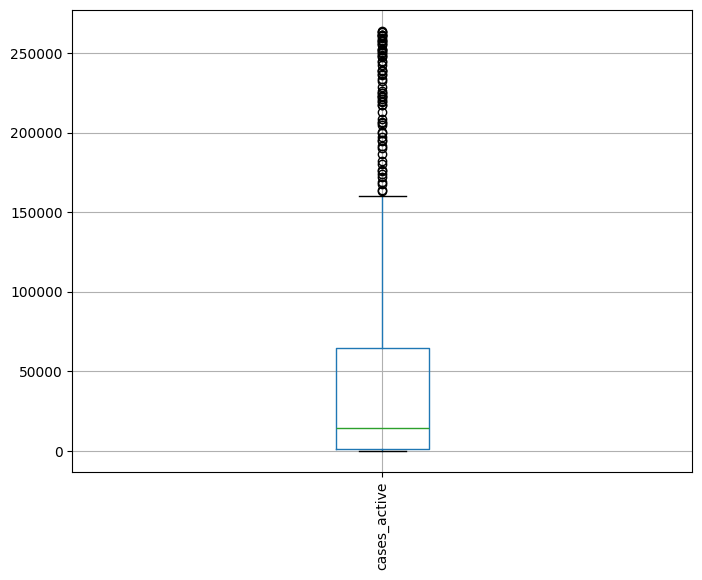

In [12]:
#(E) Checking the distribution of the data
def plot_boxplot(data, columns):
    data.boxplot(column=columns)
    plt.xticks(rotation=90)
    plt.show()
columns_except_active = ['cases_new', 'cases_import', 'cases_recovered',
                        'cases_cluster', 'cases_unvax', 'cases_pvax', 'cases_fvax',
                        'cases_boost', 'cases_child', 'cases_adolescent', 'cases_adult',
                        'cases_elderly', 'cases_0_4', 'cases_5_11', 'cases_12_17',
                        'cases_18_29', 'cases_30_39', 'cases_40_49', 'cases_50_59',
                        'cases_60_69', 'cases_70_79', 'cases_80', 'cluster_import',
                        'cluster_religious', 'cluster_community', 'cluster_highRisk',
                        'cluster_education', 'cluster_detentionCentre', 'cluster_workplace']
plot_boxplot(train_df, columns_except_active)
plot_boxplot(train_df, ['cases_active'])

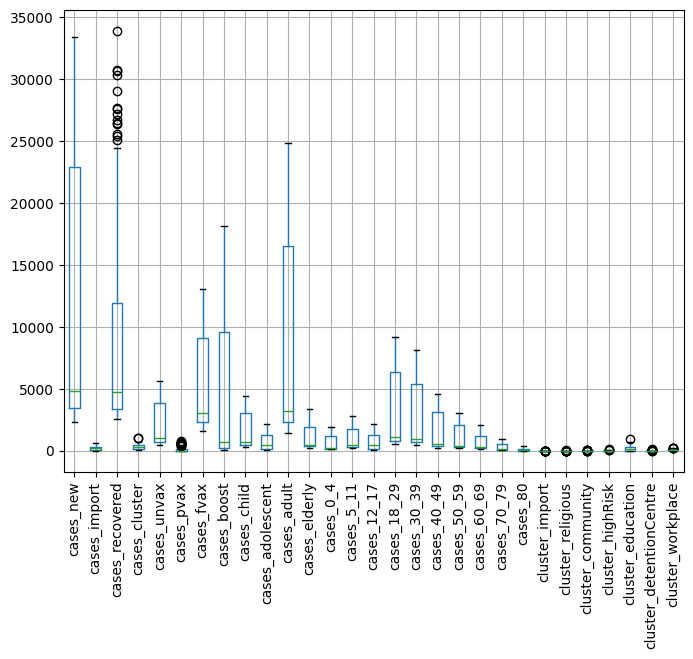

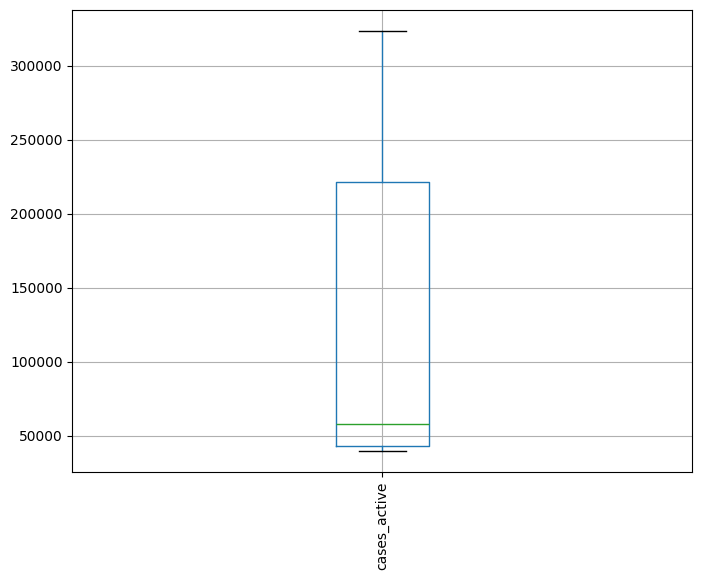

In [13]:
plot_boxplot(test_df, columns_except_active)
plot_boxplot(test_df, ['cases_active'])

In [14]:
#6. Find the high correlation towards new cases for the prediction
correlation_matrix = train_df.corr()
correlation_with_cases_new = correlation_matrix['cases_new']
high_correlation = correlation_with_cases_new[correlation_with_cases_new > 0.90].index
print(high_correlation)

Index(['cases_new', 'cases_recovered', 'cases_active', 'cases_unvax',
       'cases_pvax', 'cases_child', 'cases_adolescent', 'cases_adult',
       'cases_elderly', 'cases_0_4', 'cases_5_11', 'cases_12_17',
       'cases_18_29', 'cases_30_39', 'cases_40_49', 'cases_50_59',
       'cases_60_69', 'cases_70_79', 'cases_80'],
      dtype='object')


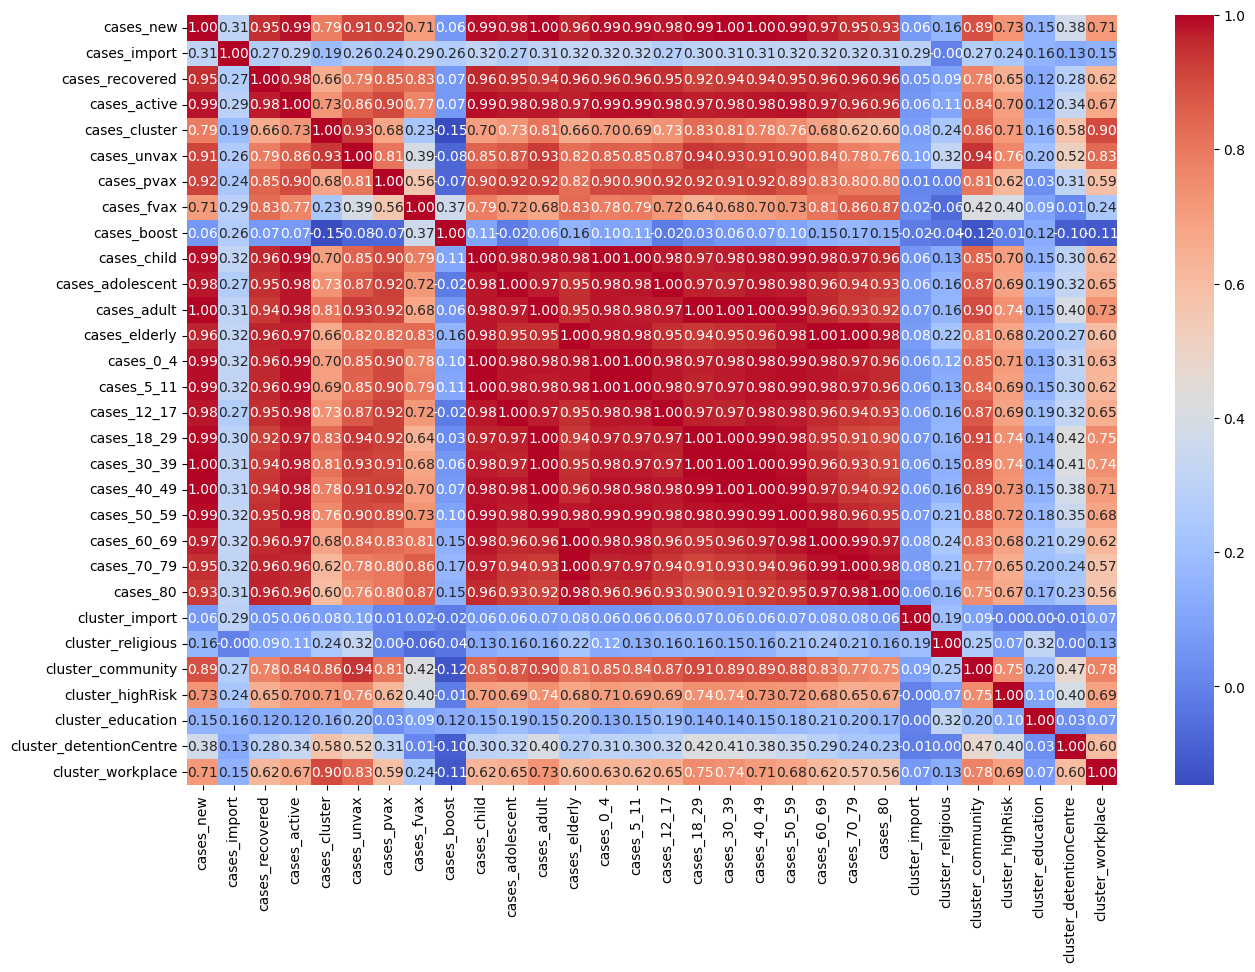

In [15]:
# Correlation Map between all the columns between new cases
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()


In [16]:
# Picking only the features with high correlation
features =['cases_new', 'cases_recovered', 'cases_active', 'cases_unvax',
       'cases_pvax', 'cases_child', 'cases_adolescent', 'cases_adult',
       'cases_elderly', 'cases_0_4', 'cases_5_11', 'cases_12_17',
       'cases_18_29', 'cases_30_39', 'cases_40_49', 'cases_50_59',
       'cases_60_69', 'cases_70_79', 'cases_80']

train_df = train_df[features]
test_df = test_df[features]

In [17]:
#7. Train validation test split
column_indices = {name: i for i, name in enumerate(train_df.columns)}
df = train_df
n = len(train_df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*1.0)]
test_df = test_df[:]
num_features = train_df.shape[1]

In [18]:
#8. Normalize the data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [19]:
# Function to compile and run the data
def compile_and_fit(model, window, epochs=20, patience=3):
    early_stopping = EarlyStopping(monitor='loss',
                                   patience=patience,
                                   mode='min')
    
    logpath = os.path.join('tensorboard_log', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tb = TensorBoard(logpath)

    optimizer = Adam(learning_rate=0.001)
    loss = MeanAbsoluteError()
    metrics = [MeanAbsolutePercentageError(),'mae']

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    history = model.fit(window.train, epochs=epochs,
                        callbacks=[early_stopping, tb], batch_size=64)

    return history

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['cases_new']


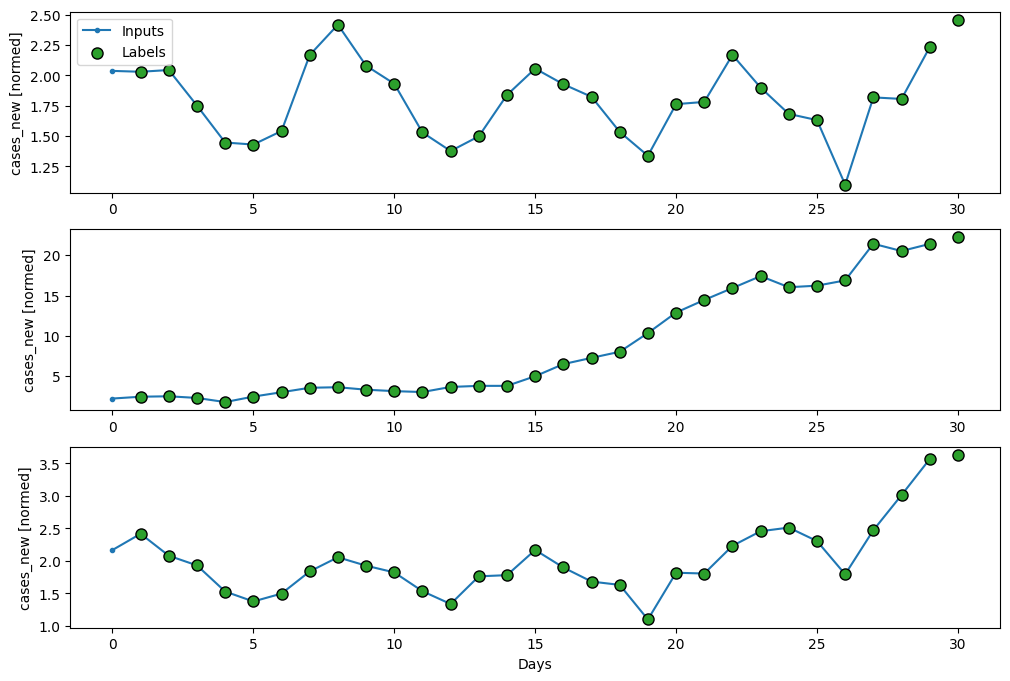

In [20]:
#9. Single step prediction
#(A) single-step window
single_window = WindowGenerator(
    train_df=train_df,test_df=test_df, val_df=val_df,
    input_width=30, label_width=30, shift=1,
    label_columns=['cases_new'], batch_size=64)

print(single_window)
single_window.plot()

In [21]:
# Create the single step model
single_model = Sequential()
single_model.add(LSTM(40, return_sequences=True, input_shape=(30, num_features)))
single_model.add(Dropout(0.2))
single_model.add(Dense(1))

history_single = compile_and_fit(single_model,single_window,epochs=50)

Epoch 1/50
7/7 [==============================] - 4s 8ms/step - loss: 0.4638 - mean_absolute_percentage_error: 112.4036 - mae: 0.4638
Epoch 2/50
7/7 [==============================] - 0s 8ms/step - loss: 0.3135 - mean_absolute_percentage_error: 122.3998 - mae: 0.3135
Epoch 3/50
7/7 [==============================] - 0s 7ms/step - loss: 0.2766 - mean_absolute_percentage_error: 115.9992 - mae: 0.2766
Epoch 4/50
7/7 [==============================] - 0s 8ms/step - loss: 0.2445 - mean_absolute_percentage_error: 102.4278 - mae: 0.2445
Epoch 5/50
7/7 [==============================] - 0s 32ms/step - loss: 0.2220 - mean_absolute_percentage_error: 83.3191 - mae: 0.2220
Epoch 6/50
7/7 [==============================] - 0s 10ms/step - loss: 0.2070 - mean_absolute_percentage_error: 78.3962 - mae: 0.2070
Epoch 7/50
7/7 [==============================] - 0s 11ms/step - loss: 0.1965 - mean_absolute_percentage_error: 78.1008 - mae: 0.1965
Epoch 8/50
7/7 [==============================] - 0s 10ms/step

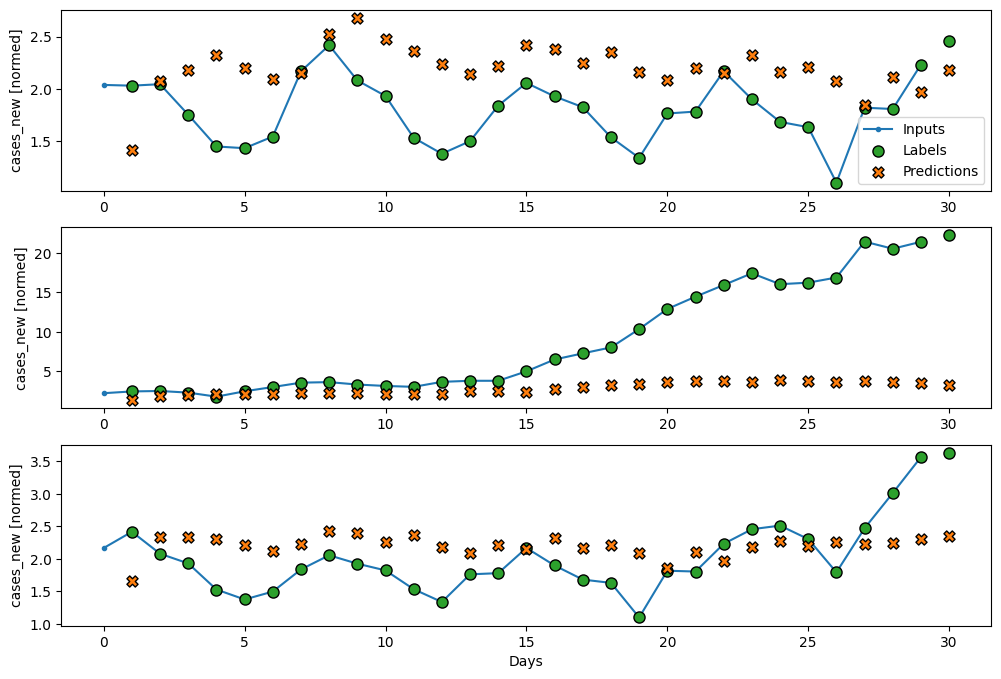

In [22]:
single_window.plot(single_model)

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Label column name(s): ['cases_new']


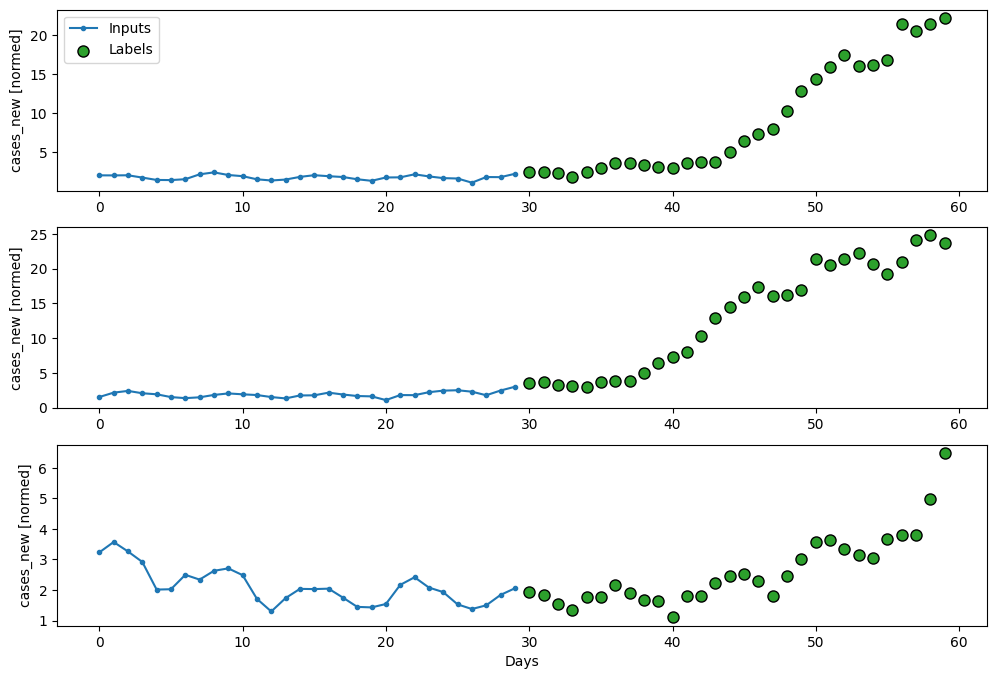

In [23]:
#(B) multi-step window
OUT_STEPS = 30
multi_window = WindowGenerator(train_df=train_df, val_df=val_df,
                               test_df=test_df,
                               input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS, label_columns= ['cases_new'])

print(multi_window)
multi_window.plot()


In [24]:
# Multi step LSTM
multi_lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(30, num_features)),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    LSTM(32, return_sequences=False),  
    Dropout(0.3),
    Dense(OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()),
    Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window, epochs=50)

Epoch 1/50
13/13 [==============================] - 6s 23ms/step - loss: 0.7221 - mean_absolute_percentage_error: 99.7519 - mae: 0.7221
Epoch 2/50
13/13 [==============================] - 0s 14ms/step - loss: 0.5183 - mean_absolute_percentage_error: 152.4532 - mae: 0.5183
Epoch 3/50
13/13 [==============================] - 0s 24ms/step - loss: 0.3733 - mean_absolute_percentage_error: 185.7595 - mae: 0.3733
Epoch 4/50
13/13 [==============================] - 0s 18ms/step - loss: 0.3430 - mean_absolute_percentage_error: 197.4371 - mae: 0.3430
Epoch 5/50
13/13 [==============================] - 0s 15ms/step - loss: 0.3226 - mean_absolute_percentage_error: 161.9601 - mae: 0.3226
Epoch 6/50
13/13 [==============================] - 0s 16ms/step - loss: 0.3054 - mean_absolute_percentage_error: 136.9329 - mae: 0.3054
Epoch 7/50
13/13 [==============================] - 0s 14ms/step - loss: 0.2961 - mean_absolute_percentage_error: 129.4105 - mae: 0.2961
Epoch 8/50
13/13 [========================

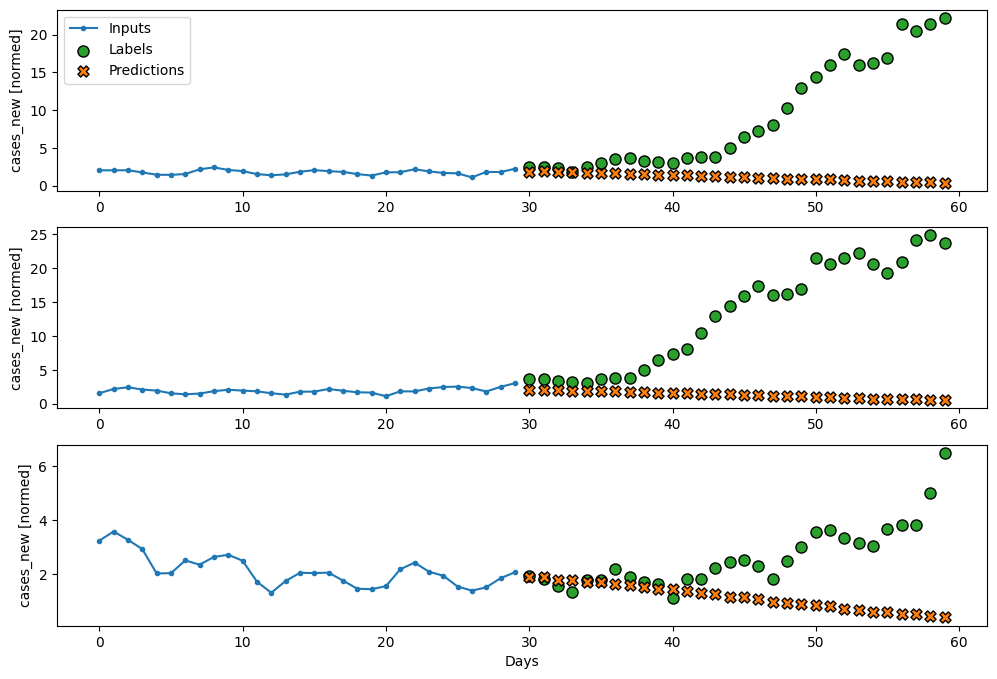

In [25]:
multi_window.plot(multi_lstm_model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 40)            9600      
                                                                 
 dropout (Dropout)           (None, 30, 40)            0         
                                                                 
 dense (Dense)               (None, 30, 1)             41        
                                                                 
Total params: 9,641
Trainable params: 9,641
Non-trainable params: 0
_________________________________________________________________


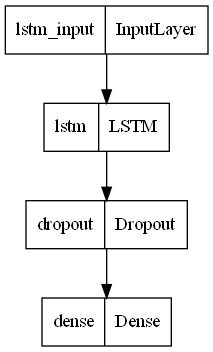

In [27]:
# Display the single model summary and architecture
single_model.summary()
tf.keras.utils.plot_model(single_model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30, 64)            21504     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 570)               18810     
                                                                 
 reshape (Reshape)           (None, 30, 19)           

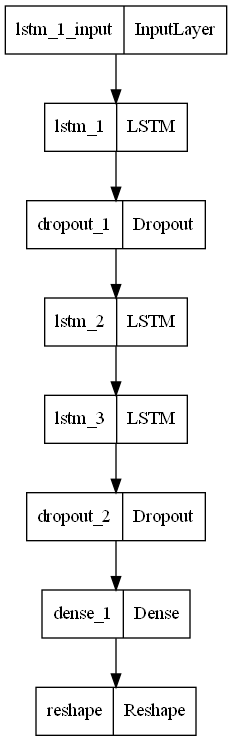

In [31]:
# Display the multi model summary and architecture
multi_lstm_model.summary()
tf.keras.utils.plot_model(multi_lstm_model)